In [1]:
import librosa as lb
import os, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from librosa.display import specshow, waveplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix

np.random.seed(9) #For the Mighty Nein!

## Phase 4: Modeling

### 4.1 Function Definitions

In [2]:
# Dictionaries to parse file names
emotions = {
    '01' : 'neutral',
    '02' : 'calm',
    '03' : 'happy',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disgust',
    '08' : 'surprised'
}
vocal_channels = {
    '01' : 'speech',
    '02' : 'song'
}
emotional_intensities = {
    '01' : 'normal',
    '02' : 'strong'
}
statements = {
    '01' : 'Kids are talking by the door',
    '02' : 'Dogs are sitting by the door'
}


In [3]:
def extract_feature(file, mfcc, chroma, mel):
    audio, sample_rate = lb.load(file)
    stft=np.abs(lb.stft(audio))
    result = []
    
    if mfcc:
        mfccs=np.mean(lb.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        result.extend(mfccs)
    if chroma:
        chroma_r=np.mean(lb.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result.extend(chroma_r)
    if mel:
        mel=np.mean(lb.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
        result.extend(mel)
    return result

In [4]:
def load_targets_df(target_emotions, target_actors, target_channels = ['song', 'speech']):
    #load files that contain target emotion
    sounds = []
    
    for file in glob.glob('./data/samples/*.wav'):
        file_name = os.path.basename(file)
        
        #filter out non-target channels- set to all by default
        channel = vocal_channels[file_name.split('-')[1]]
        if channel not in target_channels:
            continue
            
        #filter out non-target emotions
        emotion = emotions[file_name.split('-')[2]]
        if emotion not in target_emotions:
            continue
            
        #filter out non-target actors
        actor = file_name.split('-')[6][:-4]
        if actor not in target_actors:
            continue
        
        sound_dict = {
            'file_name'  : file_name[:-4],
            'emotion'    : emotions[file_name.split("-")[2]],
            'feature'    : extract_feature(file, mfcc = True, chroma = True, mel = True)
        }
        
        sounds.append(sound_dict)
        
    return pd.DataFrame.from_dict(sounds)

In [5]:
def plot_loss(res, title, figsize = (12,8)):
    train_loss = res.history['loss']
    test_loss = res.history['val_loss']
  
    plt.figure(figsize = figsize)
    plt.plot(train_loss, label='Training loss', color='navy')
    plt.plot(test_loss, label='Testing loss', color='skyblue')
    
    plt.title(title)
    plt.legend();

In [6]:
def plot_accuracy(res, title, figsize = (12,8)):
    train_accuracy = res.history['accuracy']
    test_accuracy = res.history['val_accuracy']

    plt.figure(figsize = figsize)
    plt.plot(train_accuracy, label = 'Training Accuracy', color = 'lightgreen')
    plt.plot(test_accuracy, label = 'Testing Accuracy', color = 'darkgreen')
    
    plt.title(title)
    plt.legend();

In [7]:
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred_pct = model.predict(X_test)
    label_dict = dict(enumerate(y_test.columns))
    y_pred = np.vectorize(label_dict.get)(np.argmax(y_pred_pct, axis = 1))
    y_test_flat = pd.Series(y_test.columns[np.where(y_test!=0)[1]])
    cm = confusion_matrix(y_test_flat, y_pred)
    
    sns.heatmap(cm, annot = True, cmap = 'Greens', xticklabels = y_test.columns, yticklabels= y_test.columns)
    plt.title(title);

In [8]:
sample_path = 'data/samples/03-01-01-01-01-01-01.wav'
sample = extract_feature(sample_path, mfcc = True, chroma = True, mel = True)

In [9]:
len(sample)

180

In [10]:
tar_emotions = ['happy', 'sad', 'angry', 'fearful']
# using the four emotions where a sample exists for both speech and song channels

tar_actors = ['01', '02', '03', '04', '05', '06', '07',
              '08', '09', '10', '11', '12', '13', '14',
              '15','16', '17', '18', '19', '20'] 
# setting aside the last 4 actors as holdout data

In [11]:
df = load_targets_df(tar_emotions, tar_actors)

In [12]:
df['feature_length'] = [len(feature) for feature in df['feature']]

In [13]:
df['feature_length'].value_counts()

180    1248
Name: feature_length, dtype: int64

In [14]:
X = np.stack(df['feature'].to_numpy())
y = df['emotion'].copy()
y = pd.get_dummies(y, columns = ['emotion'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
n_input = X_train[0].shape

In [24]:
model = Sequential()
model.add(Dense(512,
               activation = 'relu',
               input_shape = n_input))
model.add(Dropout(0.25))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation = 'softmax'))
          
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [25]:
res = model.fit(X_train, y_train,
               validation_data = (X_test, y_test),
               epochs = 250,
               verbose = 0)

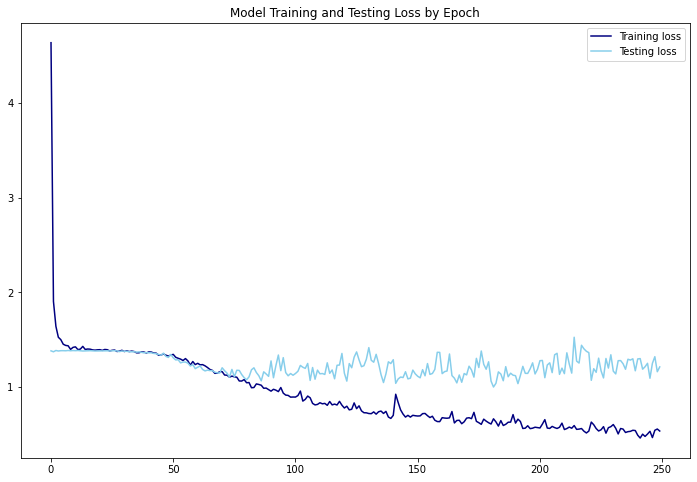

In [26]:
plot_loss(res, 'Model Training and Testing Loss by Epoch')

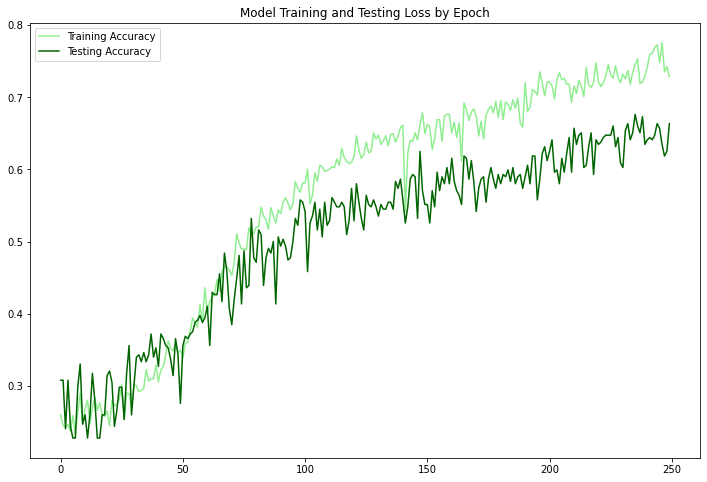

In [27]:
plot_accuracy(res, 'Model Training and Testing Loss by Epoch')

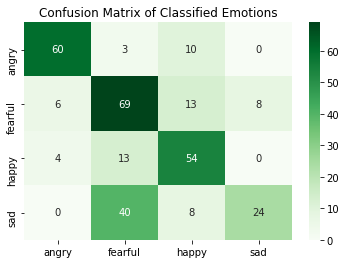

In [28]:
plot_confusion_matrix(model, X_test, y_test, "Confusion Matrix of Classified Emotions")

In [23]:
speech_tar_emotions = list(emotions.values())

speech_df = load_targets()

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']